In [1]:
from diffusers import AutoencoderKL
from accelerate import Accelerator
from _utils import *

DIFF_MODEL = "CompVis/stable-diffusion-v1-4"
dtype=torch.float32
data_path = '../data/'
res_path = '../res/'
H = 512
W = 392
TRAIN = False
NERF = True
SCALE = False

In [2]:
if NERF:
    nf = NerfDataset(data_path, res_path, SCALE)
    dataset = nf
else:
    dataset = ImageDataset(data_path, dtype, H, W)
    
vae = AutoencoderKL.from_pretrained(DIFF_MODEL,subfolder="vae", torch_dtype=dtype).to('cuda')
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)
dataloader = DataLoader(dataset, batch_size=1)

accelerator = Accelerator()
vae, optimizer, dataloader = accelerator.prepare(vae, optimizer, dataloader)

In [3]:
if TRAIN:
    vae.apply(initialize_weights)
    vae.train()
    num_epochs = 30
    for epoch in range(num_epochs):
        for batch in dataloader:
            optimizer.zero_grad()
            data_org = batch
            with accelerator.autocast():
                data_rec = vae(data_org).sample
                loss = criterion(data_rec, data_org)
                if TRAIN:
                    accelerator.backward(loss)
                    optimizer.step()
            
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")
            print('Recon')
            plt_img(data_rec[0])
            
            del data_org, data_rec, loss
            torch.cuda.empty_cache()

tensor(0.0236, dtype=torch.float64)


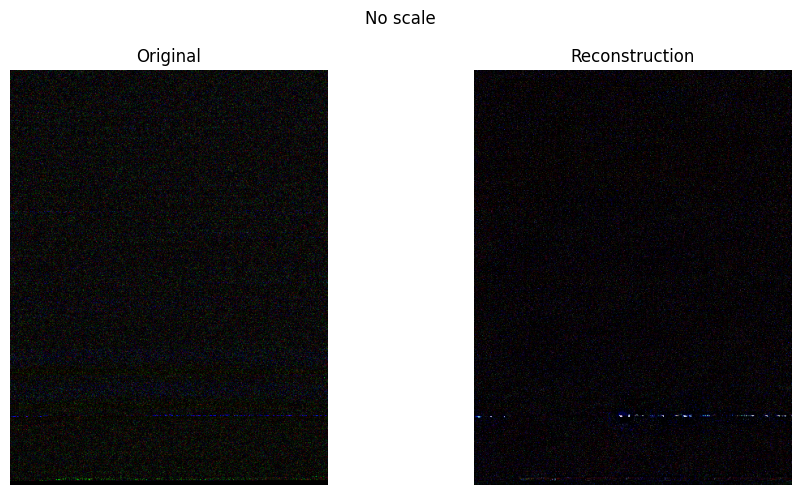

In [4]:
with torch.no_grad():
    if NERF:
        enc3_recs = vae(nf.npy).sample
        res = nf.decode(enc3_recs)
        uns_org = nf.enc3_1['uns_org']
        uns_rec = res[0]['uns_rec']
        compare_img('No scale', uns_org, uns_rec, criterion)
        # compare_img(res[1]['rec_uns'], nf.enc3_2['org_uns'], criterion)
        if SCALE:
            scl_org = nf.enc3_1['scl_org']
            scl_rec = res[0]['scl_rec']
            compare_img('Scale', scl_org, scl_rec, criterion)
            # compare_img(res[1]['rec_scl'], nf.enc3_2['org_scl'], criterion)

    else:
        img_org = make_image(data_path, dtype, H, W)
        img_rec = vae(img_org).sample
        compare_img(img_org, img_rec, criterion)

In [6]:
nf.save_dec_npy(res)

save to ../res/model_200000.npy
save to ../res/model_fine_200000.npy


In [5]:
# criterion = torch.nn.MSELoss()
# optimizerEnc = torch.optim.Adam(vae.encoder.parameters(), lr=1e-4)
# optimizerDec = torch.optim.Adam(vae.decoder.parameters(), lr=1e-4)
# accelerator = Accelerator()
# 
# def kl_loss(mu, logvar):
#     return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
# 
# vae, optimizerEnc, optimizerDec, dataloader = accelerator.prepare(vae, optimizerEnc, optimizerDec, dataloader)
# num_epochs = 30
# for epoch in range(num_epochs):
#     for batch in dataloader:
#         optimizerEnc.zero_grad()
#         optimizerDec.zero_grad()
#         
#         data_org = batch
#         with accelerator.autocast():
#             latent = vae.encode(data_org).latent_dist
#             
#             loss_Enc = kl_loss(latent.mean, latent.logvar)
#             if TRAIN:
#                 accelerator.backward(loss_Enc)
#                 optimizerEnc.step()
#             
#             z = latent.mode().data
#             data_rec = vae.decode(z).sample
#             
#             loss_Dec = criterion(data_rec, data_org)
#             if TRAIN:
#                 accelerator.backward(loss_Dec)
#                 optimizerDec.step()
#         
#         print(f"Epoch [{epoch+1}/{num_epochs}], LossEnc: {loss_Enc.item()} LossDec: {loss_Dec.item()}")
#         print('Recon')
#         plt_img(data_rec[0])
#         
#         del data_rec, latent, z, loss_Enc, loss_Dec
#         torch.cuda.empty_cache()